# Adult *Drosophila melanogaster* Antennal Lobe
In this notebook, we go through the following examples in which we simulate the antennal lobe of adult *Drosophila melanogaster*. 

1. Simulating Adult Antennal Lobe with inferred affinity values.
2. Simulating Adult Antennal Lobe with inferred affinity values for the Hemibrain dataset.

You can download the files you need for this example from https://ffbodata.neuronlp.fruitflybrain.org/adultdrosophila/.

In [1]:
%load_ext autoreload
%autoreload 2

import typing as tp
import numpy as np
from itertools import product
from eoscircuits import al
import olftrans as olf
import olftrans.data
import olftrans.fbl
from olftrans.plot import plot_mat
from neurokernel.LPU.InputProcessors.StepInputProcessor import StepInputProcessor
import matplotlib.pyplot as plt
import typing as tp
import pandas as pd
import seaborn as sns
from eoscircuits.plot import plot_data, plot_spikes
import os

/mnt/server-home/mehmet/OlfTrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))
/mnt/server-home/mehmet/OlfTrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))


## Setup

In [2]:
class AdultDrosophilaEOS:
    """Adult Drosophila early olfactory system class."""
    def __init__(self, file_path = 'adult_hallem06.csv', model_type = 'hemibrain', file_folder = './'):
        """Initializes the Adult Drosophila early olfactory system class.
        
        # Arguments:
            file_path (str): File path for the affinities csv file. Defaults to 'adult_hallem06.csv'.
            model_type (str): Model type to use. 'hemibrain' or 'flycircuit'. Defaults to 'hemibrain'.
            file_folder (str): File folder in which to expect the extra connectivity files. Defaults to './'.
        """
        self.file_folder = './'
        self.file_path = file_path
        self.model_type = model_type
        self.load_odorant()
        
    def load_odorant(self, odorant_name = 'putrescine'):
        """Loads an odorant for simulation.
        
        # Arguments:
            odorant_name (str): Odorant name to load. Defaults to 'putrescine'.
        """
        df = pd.read_csv(self.file_path)
        all_odorant_names = list(df.iloc[:,0])
        glom_names = ['VP3', 'VC3l', 'VP5', 'DL2v', 'V', 'VL2a', 'VC5', 'DM4', 'DM3', 'DA4m', 'VP2', 'VP1l', 'DL2d', 'VP1m', 'DM5', 'DC4', 'DA1', 'VA3', 'VM2', 'D', 'VL2p', 'VM5d', 'VA1v', 'DL3', 'VA7m', 'DA2', 'VM7d', 'VC3m', 'VM1', 'VM4', 'VA4', 'DL1', 'DC1', 'DA4l', 'DP1m', 'VA2', 'VA1d', 'DM2', 'DP1l', 'VC4', 'VM7v', 'VA5', 'VA6', 'DC2', 'DM1', 'DL4', 'VA7l', 'DM6', 'VM3', 'VM5v', 'VC2', 'DA3', 'DC3', 'DL5', 'VC1', 'VL1']
        GL_to_OR = {
                'D': {'receptors': ['OR69a','OR69b'], 'name': 'ab9', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DA1': {'receptors': ['OR67d'], 'name': 'at1A', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DA2': {'receptors': ['OR33a','OR56a'], 'name': 'ab4B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DA3': {'receptors': ['OR23a'], 'name': 'at2B', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DA4l': {'receptors': ['OR43a'], 'name': 'at3', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DA4m': {'receptors': ['OR2a'], 'name': 'at3', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DC1': {'receptors': ['OR19a','OR19b'], 'name': 'at3A', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DC2': {'receptors': ['OR13a'], 'name': 'ab6A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DC3': {'receptors': ['OR83c'], 'name': 'at2A', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DC4': {'receptors': ['IR64a'], 'name': 'Sac III', 'co-receptors': ['IR8a'], 'sensillum': 'sacculus', 'sensillum location': 'antenna'},
                'DL1': {'receptors': ['OR10a','GR10a'], 'name': 'ab1D', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DL2d': {'receptors': ['IR75b'], 'name': 'ac3A', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'DL2v': {'receptors': ['IR75c'], 'name': 'ac3A', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'DL3': {'receptors': ['OR65a','OR65b','OR65c'], 'name': 'at4B', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'DL4': {'receptors': ['OR49a','OR85f'], 'name': 'ab10B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DL5': {'receptors': ['OR7a'], 'name': 'ab4A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM1': {'receptors': ['OR42b'], 'name': 'ab1A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM2': {'receptors': ['OR22a','OR22b'], 'name': 'ab3A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM3': {'receptors': ['OR47a','OR33b'], 'name': 'ab5B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM4': {'receptors': ['OR59b'], 'name': 'ab2A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM5': {'receptors': ['OR33b','OR85a'], 'name': 'ab2B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DM6': {'receptors': ['OR67a'], 'name': 'ab10B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'DP1l': {'receptors': ['IR75a'], 'name': 'ac2', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'DP1m': {'receptors': ['IR64a'], 'name': 'Sac III', 'co-receptors': ['IR8a'], 'sensillum': 'sacculus', 'sensillum location': 'antenna'},
                'V': {'receptors': ['GR21a','GR63a'], 'name': 'ab1C', 'co-receptors': [], 'sensillum': 'sacculus', 'sensillum location': 'antenna'},
                'DA4l': {'receptors': ['OR43a'], 'name': 'at3', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'VA1d': {'receptors': ['OR88a'], 'name': 'at4C', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'VA1v': {'receptors': ['OR47b'], 'name': 'at4A', 'co-receptors': ['Orco'], 'sensillum': 'trichodea', 'sensillum location': 'antenna'},
                'VA2': {'receptors': ['OR92a'], 'name': 'ab1B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VA3': {'receptors': ['OR67b'], 'name': 'ab9', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VA4': {'receptors': ['OR85d'], 'name': 'pb3B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VA5': {'receptors': ['OR49b'], 'name': 'ab6B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna pulp'},
                'VA6': {'receptors': ['OR82a'], 'name': 'ab5A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna pulp'},
                'VA7l': {'receptors': ['OR46a'], 'name': 'pb2B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VA7m': {'receptors': [], 'name': '', 'co-receptors': [], 'sensillum': 'unknown', 'sensillum location': 'unknown'},
                'VC1': {'receptors': ['OR33c,OR85e'], 'name': 'pb2A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VC2': {'receptors': ['OR71a'], 'name': 'pb1B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VC3l': {'receptors': ['OR35a'], 'name': 'ac1', 'co-receptors': ['Orco'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VC3m': {'receptors': [], 'name': 'unknown', 'co-receptors': ['Orco'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VC4': {'receptors': ['OR67c'], 'name': 'ab7B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VC5': {'receptors': ['IR41a'], 'name': 'IR25a,IR76b', 'co-receptors': ['Orco'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VL1': {'receptors': ['IR75d'], 'name': 'ac1', 'co-receptors': ['IR25a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VM7d': {'receptors': ['OR42a'], 'name': 'pb1A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VM7v': {'receptors': ['OR59c'], 'name': 'pb3A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'maxillary pulp'},
                'VM5v': {'receptors': ['OR98a'], 'name': 'ab7A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VM5d': {'receptors': ['OR85b','OR98b'], 'name': 'ab3B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VM4': {'receptors': ['IR76a'], 'name': 'ac4', 'co-receptors': ['IR25a','IR76b'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VM3': {'receptors': ['OR9a'], 'name': 'ab8B', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VM2': {'receptors': ['OR43b'], 'name': 'ab8A', 'co-receptors': ['Orco'], 'sensillum': 'basiconica', 'sensillum location': 'antenna'},
                'VM1': {'receptors': ['OR92a'], 'name': 'ac1', 'co-receptors': ['IR25a','IR76b'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VL2p': {'receptors': ['IR31a'], 'name': 'ac1', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VL2a': {'receptors': ['IR84a'], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VP3': {'receptors': [], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VP5': {'receptors': [], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VP2': {'receptors': [], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VP1l': {'receptors': [], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
                'VP1m': {'receptors': [], 'name': 'ac4', 'co-receptors': ['IR8a'], 'sensillum': 'coeloconica', 'sensillum location': 'antenna'},
            }

        idx_a = all_odorant_names.index('putrescine')

        b_array = np.array(list(df.iloc[idx_a,1:]))

        or_names = [i.lower() for i in list(df.columns[1:])]
        bj = []
        or_names_found = []
        or_inds_found = []
        for i, val in enumerate(glom_names):
            receptors = GL_to_OR[val]['receptors']
            found = False
            for j in receptors:
                jreal = j
                j = j.lower()
                if j in or_names:
                    bj.append(b_array[or_names.index(j)])
                    found = True
                    or_names_found.append(jreal)
                    or_inds_found.append(len(bj)-1)
            if found == False:
                bj.append(0)
        # self.ngloms = 56
        self.or_inds_found = or_inds_found
        self.or_names_found = or_names_found
        self.affinities = np.array(bj)
        self.receptor_names = np.array(or_names_found)
        self.glom_names = glom_names
        
    def generate_adult_models(self, model_type='hemibrain', file_folder = './'):
        def osn_to_preln_connectomics(self, W):
            tbl = np.empty(self.NR, dtype=np.ndarray)
            for r in range(self.NR):
                conn = []
                for i in range(W.shape[1]):
                    if W[r,i]>0.:
                        conn.append([0,i])
                tbl[r] = np.array(list(conn))
            return tbl

        def preln_to_axt_connectomics(self, W):
            tbl = np.empty(self.NR, dtype=np.ndarray)
            for r in range(self.NR):
                conn = []
                for i in range(W.shape[0]):
                    if W[i,r]>0.:
                        conn.append([i,0])
                tbl[r] = np.array(list(conn))
            return tbl

        def postln_to_pn_connectomics(self, W):
            tbl = []
            for r in range(self.NR):
                conn = []
                for i in range(W.shape[1]):
                    if W[r,i]>0.:
                        tbl.append([r,i])
            tbl = np.array(tbl)
            return tbl


        if model_type == 'hemibrain':
            preLN_field = np.load(os.path.join(file_folder, 'preLN_field.npy'))
            postLN_field = np.load(os.path.join(file_folder, 'postLN_field.npy'))
            preLN_field_a = np.load(os.path.join(file_folder, 'preLN_field_a.npy')) # 
            preLN_field_b = np.load(os.path.join(file_folder, 'preLN_field_b.npy')) # LN-to-PN
            Npre = preLN_field_a.shape[1]
            W = preLN_field_a
            W = 1. * (W>0.5)
            W2 = preLN_field_b.T
            W2 = 1. * (W2>0.5)
            W3 = postLN_field
            W3 = 1. * (W3>0.5)

            cfg = al.ALConfig(
                affs=self.affinities, NP=1, NO=1,
                NPreLN=Npre, NPosteLN=1, NPostiLN=1,
                receptors=self.glom_names,
                node_params=dict(
                    osn_bsgs=dict(sigma=0.),
                    osn_axts=dict(gamma=10.),
                    postelns=dict(a2=0.012)
                )
            )
            cfg.osn_to_preln = osn_to_preln_connectomics(cfg, W)
            cfg.preln_to_axt = preln_to_axt_connectomics(cfg, W2)
            cfg.posteln_to_pn = postln_to_pn_connectomics(cfg, W3)
            cfg.postiln_to_pn = postln_to_pn_connectomics(cfg, W3)
            al_circ = al.ALCircuit.create_from_config(cfg, connectome=True)
            return al_circ
        else:
            cfg = al.ALConfig(
                affs=self.affinities, NP=1, NO=1,
                NPreLN=1, NPosteLN=1, NPostiLN=1,
                receptors=self.glom_names,
                node_params=dict(
                    osn_bsgs=dict(sigma=0.),
                    osn_axts=dict(gamma=10.),
                    postelns=dict(a2=0.012)
                )
            )
            al_circ = al.ALCircuit.create_from_config(cfg)
            return al_circ
    def sim(self, dt=1e-5, dur=4, conc = 100.):
        """Simulates the circuit with odorant input between 1s and 3s.
        
        # Arguments:
            dt (float): Time step size in seconds. Defaults to 1e-5.
            dur (float): Simulation duration in seconds. Defaults to 4.
            conc (float): Concentration in ppm. Defaults to 100.
        """
        al_circ = self.generate_adult_models(self.model_type, file_folder = self.file_folder)
        steps = int((dur+dt/2)//dt)
        t = np.arange(steps)*dt
        fi = StepInputProcessor('conc', al_circ.inputs['conc'], conc, start=1, stop=3)
        fi, fo, lpu = al_circ.simulate(
            t, fi, 
            record_var_list=[
                (
                    'I', 
                    sum(al_circ.config.osn_otps,[]) + sum(al_circ.config.osn_axts,[]) + sum(al_circ.config.postelns,[]) + sum(al_circ.config.postilns,[])
                ),
                ('r', sum(al_circ.config.pns,[])),
                ('g', sum(al_circ.config.osn_alphas,[])),
                ('spike_state', sum(al_circ.config.osn_bsgs, []))
            ])
        return al_circ, fi, fo, lpu, t

In [3]:
dt = 1e-5
dur = 4
model = AdultDrosophilaEOS(model_type = 'flycircuit')
model.load_odorant('putrescine')
al_circ, fi, fo, lpu, t = model.sim()

56
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55']
['VP3', 'VC3l', 'VP5', 'DL2v', 'V', 'VL2a', 'VC5', 'DM4', 'DM3', 'DA4m', 'VP2', 'VP1l', 'DL2d', 'VP1m', 'DM5', 'DC4', 'DA1', 'VA3', 'VM2', 'D', 'VL2p', 'VM5d', 'VA1v', 'DL3', 'VA7m', 'DA2', 'VM7d', 'VC3m', 'VM1', 'VM4', 'VA4', 'DL1', 'DC1', 'DA4l', 'DP1m', 'VA2', 'VA1d', 'DM2', 'DP1l', 'VC4', 'VM7v', 'VA5', 'VA6', 'DC2', 'DM1', 'DL4', 'VA7l', 'DM6', 'VM3', 'VM5v', 'VC2', 'DA3', 'DC3', 'DL5', 'VC1', 'VL1']
EOS: Number of PN: 56
EOS: Number of PostLN: 112
EOS: Number of NoisyConnorStevens: 56
EOS: Number of Alpha: 56
EOS: Number of OSNAxt2: 56
EOS: Number of PreLN: 1
EOS: Number of OTP: 56
EOS: Number of Input: {'conc': 56}


EOS:   0%|          | 680/400000 [00:00<01:56, 3417.16it/s]

Compilation of executable circuit completed in 1.0076756477355957 seconds


EOS: 100%|██████████| 400000/400000 [01:56<00:00, 3429.95it/s]


affinities# 1. Simulate Larva Antennal Lobe

/home/mehmet/miniconda2/envs/eos/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


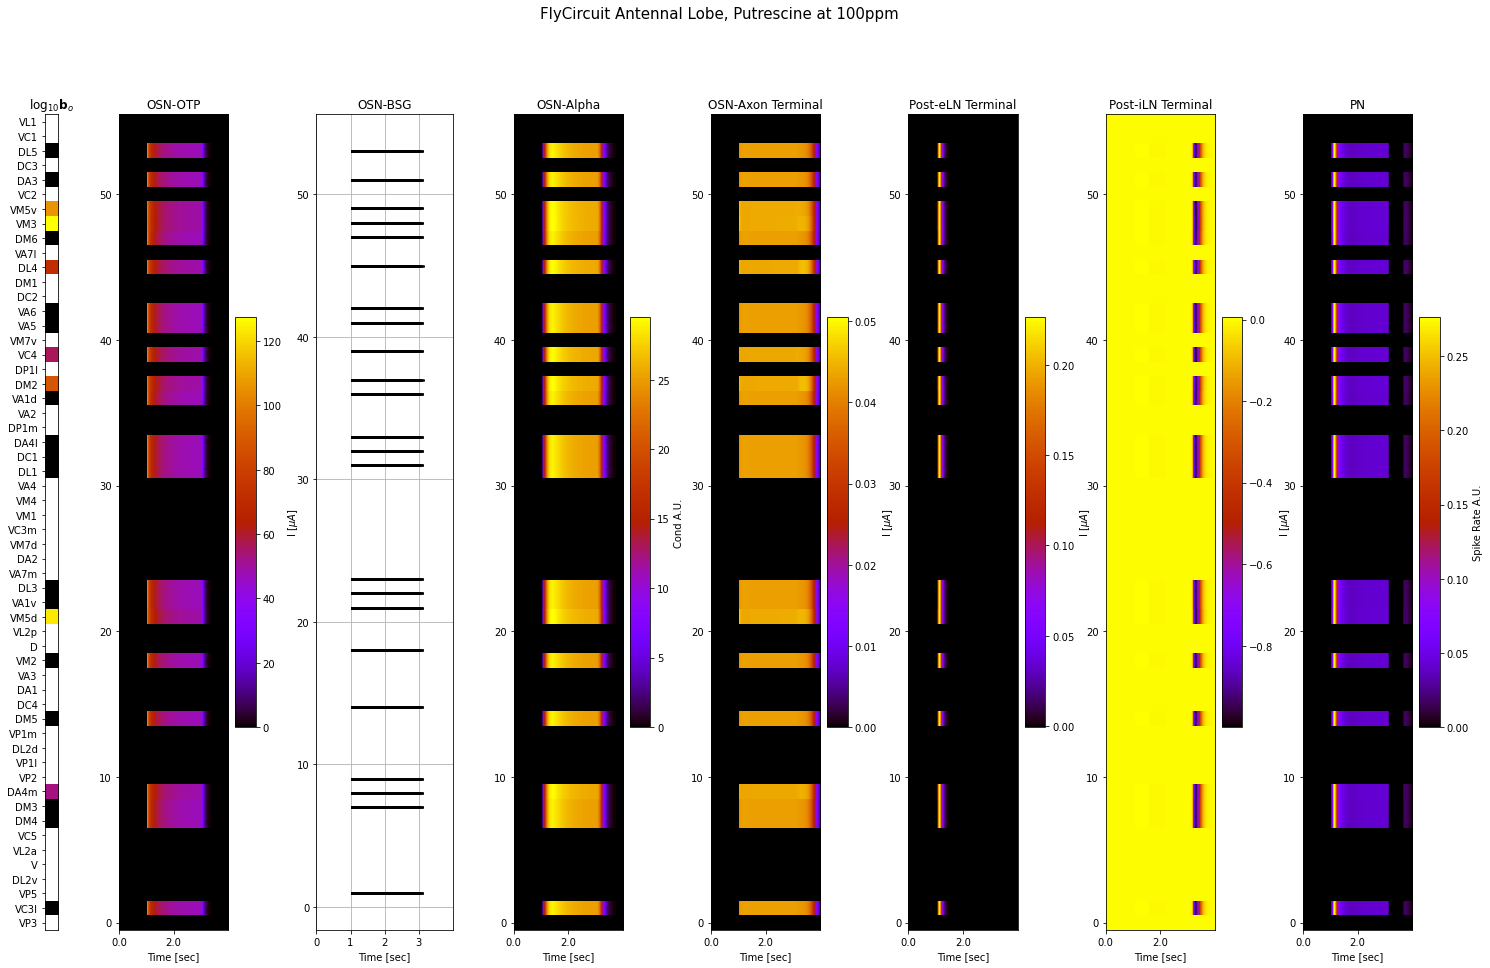

In [4]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')

fig,axes = plt.subplots(1,8, figsize=(25,15), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('FlyCircuit Antennal Lobe, Putrescine at 100ppm', fontsize=15)
plt.show()

# 2. Run with Hemibrain

In [5]:
dt = 1e-5
dur = 4
model = AdultDrosophilaEOS(model_type = 'hemibrain')
model.load_odorant('putrescine')
al_circ, fi, fo, lpu, t = model.sim()

56
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55']
['VP3', 'VC3l', 'VP5', 'DL2v', 'V', 'VL2a', 'VC5', 'DM4', 'DM3', 'DA4m', 'VP2', 'VP1l', 'DL2d', 'VP1m', 'DM5', 'DC4', 'DA1', 'VA3', 'VM2', 'D', 'VL2p', 'VM5d', 'VA1v', 'DL3', 'VA7m', 'DA2', 'VM7d', 'VC3m', 'VM1', 'VM4', 'VA4', 'DL1', 'DC1', 'DA4l', 'DP1m', 'VA2', 'VA1d', 'DM2', 'DP1l', 'VC4', 'VM7v', 'VA5', 'VA6', 'DC2', 'DM1', 'DL4', 'VA7l', 'DM6', 'VM3', 'VM5v', 'VC2', 'DA3', 'DC3', 'DL5', 'VC1', 'VL1']
EOS: Number of PN: 56
EOS: Number of PostLN: 112
EOS: Number of NoisyConnorStevens: 56
EOS: Number of Alpha: 56
EOS: Number of OSNAxt2: 56
EOS: Number of PreLN: 56
EOS: Number of OTP: 56
EOS: Number of Input: {'g': 2, 'conc': 56}


EOS:   0%|          | 642/400000 [00:00<02:04, 3219.39it/s]

Compilation of executable circuit completed in 1.3103744983673096 seconds


EOS: 100%|██████████| 400000/400000 [02:04<00:00, 3205.46it/s]


/home/mehmet/miniconda2/envs/eos/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


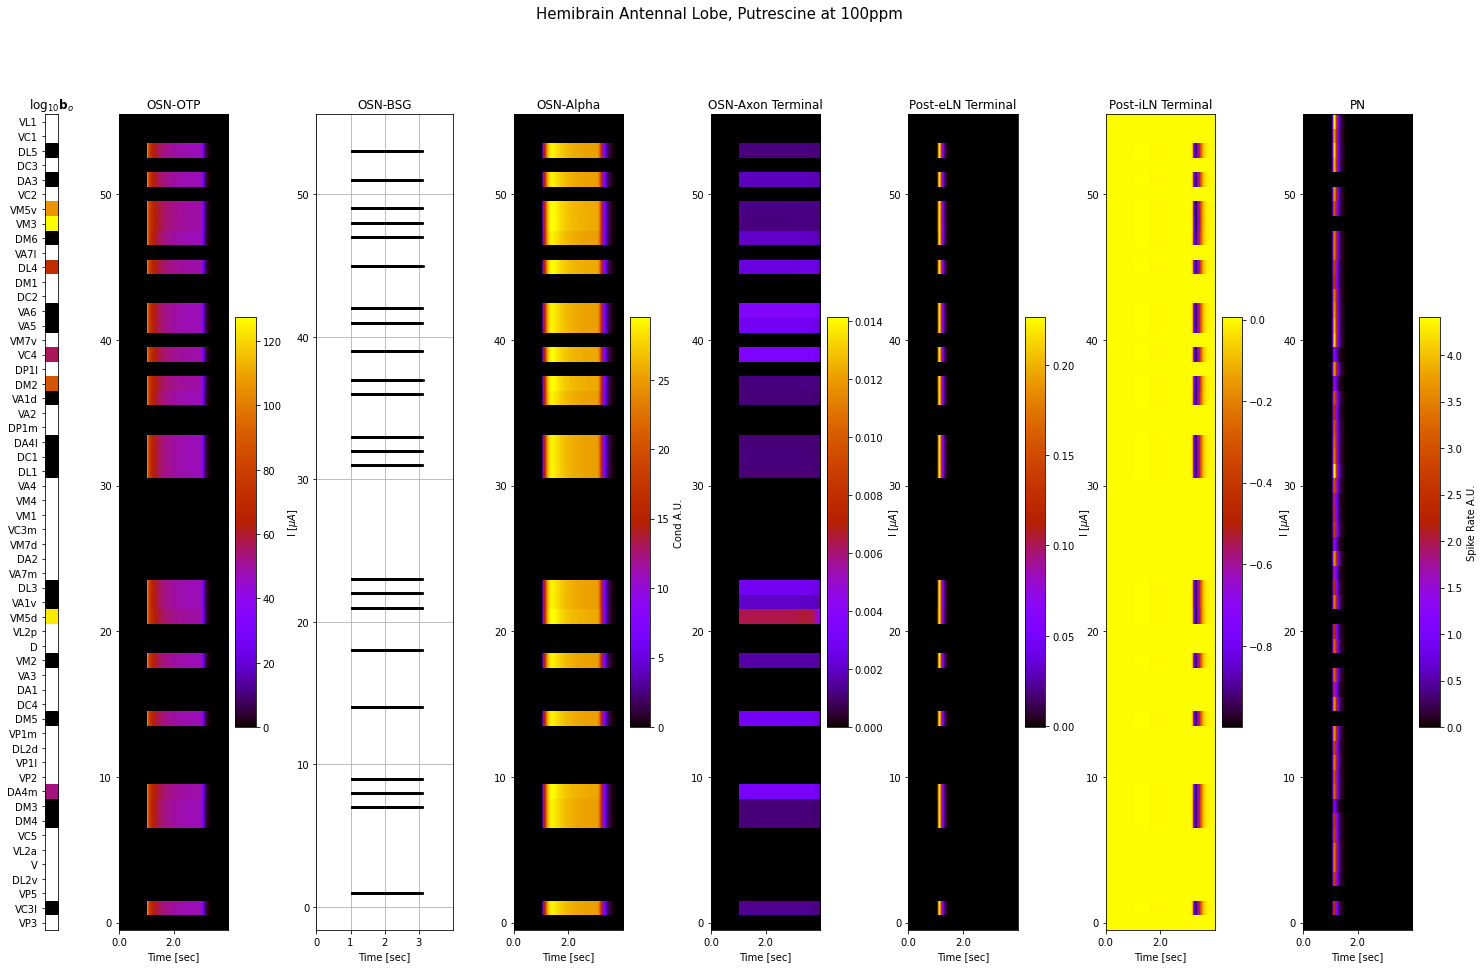

In [6]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')

fig,axes = plt.subplots(1,8, figsize=(25,15), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('Hemibrain Antennal Lobe, Putrescine at 100ppm', fontsize=15)
plt.show()